In [214]:
### Financial Econometrics II course SS 2018/2019 prof. M. Rubaszek ###

# We are going to create a portfolio of 2 chosen NASDAQ stocks and see how risky our investition is going to be #

library(quantmod)

# let's assume i like drinking pepsi whilst playing fifa so:

EA <- getSymbols("EA", auto.assign = FALSE) # EA
PEP <- getSymbols("PEP", auto.assign = FALSE) # PEPSI


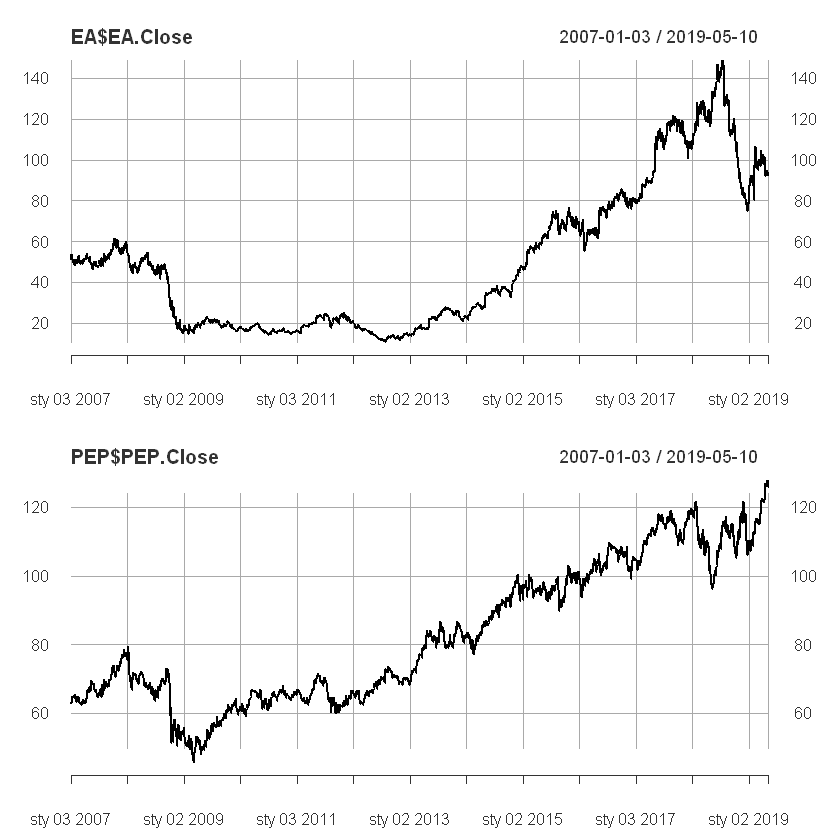

In [215]:
# Now we can look at the time series of those stocks over past 10 years #

par(mfrow=c(2,1), cex = 0.75, bty="l")
plot(EA$EA.Close)
plot(PEP$PEP.Close)

# As we can see there was a huge breakdown around 2008 #

# There was also a huge drop in EA stock price in second half of 2018 #
# It may be related to disappointing sales results of Battlefield V #
# Let's hope Anthem is going to be a bigger success #

In [216]:
# We can calculate the Pearsons correlation coefficient between the stocks #

cor(EA$EA.Close, PEP$PEP.Close)

,PEP.Close
EA.Close,0.8489802


In [217]:
# Some data manipulation #

Y<-merge(EA,PEP)
Y = Y[,c(4,10)]
head(Y)

           EA.Close PEP.Close
2007-01-03    51.05     62.72
2007-01-04    53.67     63.15
2007-01-05    53.07     62.95
2007-01-08    52.88     63.09
2007-01-09    52.70     63.35
2007-01-10    53.68     64.15

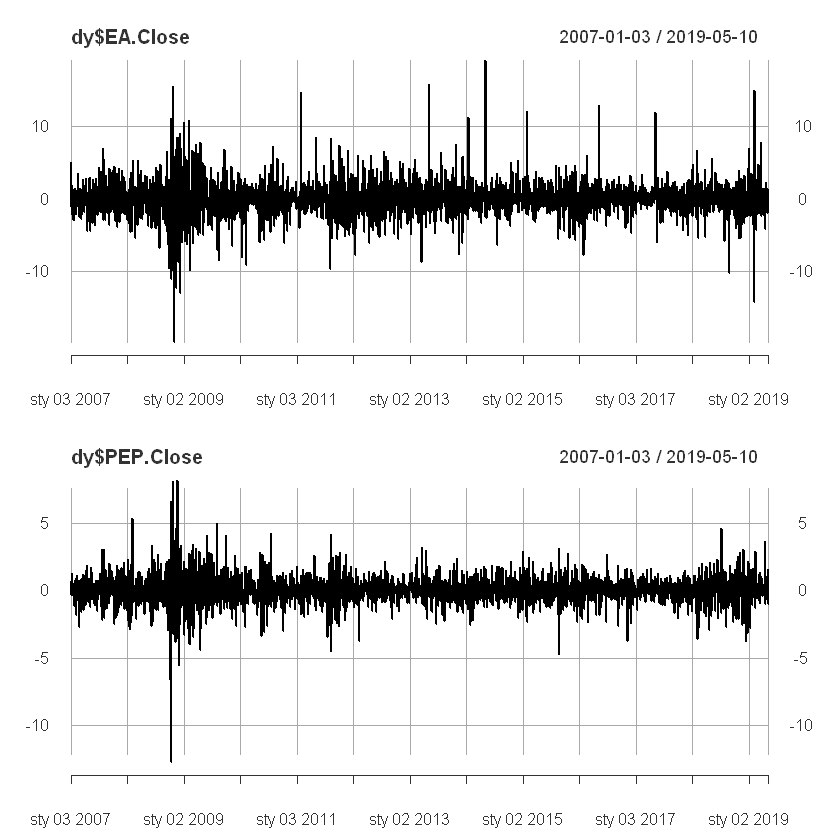

In [218]:
#Let's look at differences of log returns of the stocks#

dy  <- 100*diff(log(Y))
par(mfrow=c(2,1), cex=0.7, bty="l", lwd=1)
plot(dy$EA.Close)
plot(dy$PEP.Close)

# As expected there was a period of high volatility around 2008 #
# We can observe some relativly calm periods and some with higher volatility #
# Can one say 2018/2019 was also a bit nervous? #

In [219]:
## Creating portfolio ##

# Let's choose weights of our porfolio #
# For me pepsi > fifa so: #

w   <- c(0.35, 0.65)

# Let's create a variable with returns of ours portfolio over past 10 years
r   <- zoo(dy%*%w,index(dy))
R   <- as.numeric(coredata(r))
r[1] = 0 # in order to avoid NAs
R[1] = 0 # -||-

## The most important thing for every investor ##

# Portfolio value over time #
P   <- exp(cumsum(r/100))

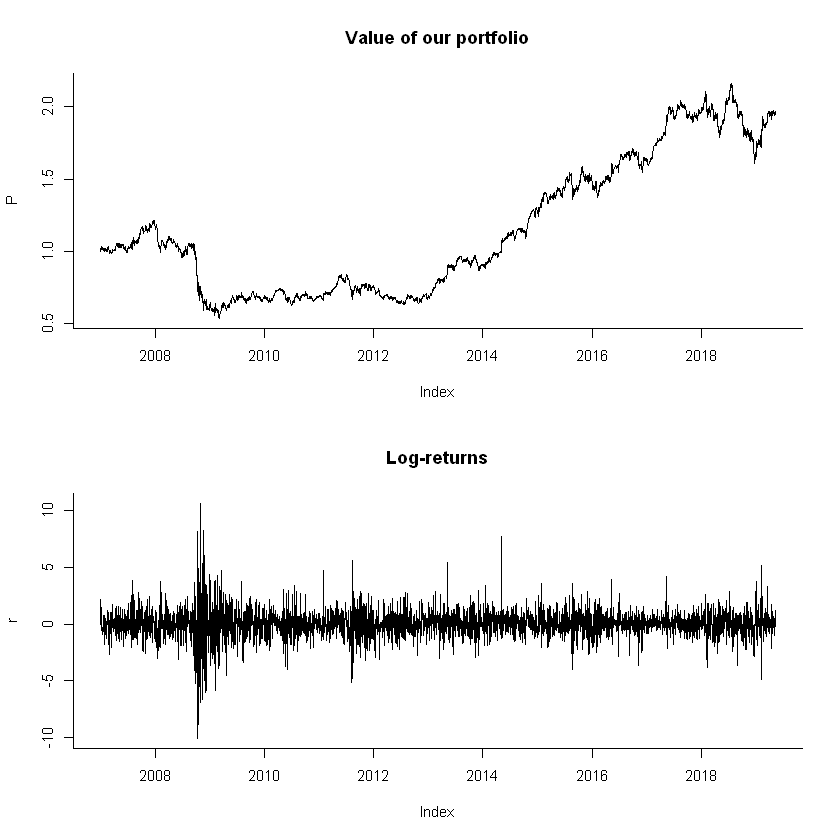

In [220]:
# Now we can visualise our portfolio #

par(mfrow=c(2,1), cex = 0.75, bty="l")
plot(P, main="Value of our portfolio")
plot(r, main="Log-returns")


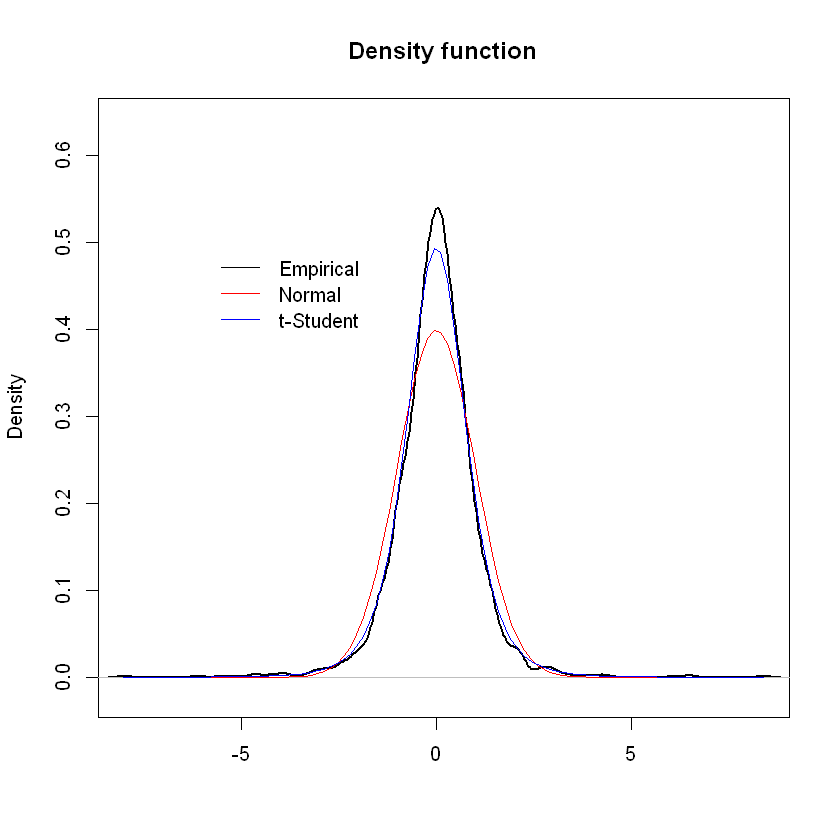

In [221]:
## Let's look at the distribution of standarized returns of our portfolio compared to N(0,1) and t-distribution with estimated v


require(rugarch)

plot(d, main="Density function", xlim = xlim, ylim = ylim, lwd=2,xlab="") 

xfit <-seq(min(Rstar),max(Rstar),length=100); 

# normal distribution
yfit <-dnorm(xfit,0,1);               
lines(xfit, yfit, lwd=1, col="red") 

# t-distribution distribution
# kurtosis(R) = 3 + 6/(v-4)
v = 4 + 6/(kurtosis(R)-3)
yfit <-ddist("std",y=xfit,shape=v);   
lines(xfit, yfit, lwd=1, col="blue") 

# The alternative way below #
#yfit <-ddist("std",y=xfit,shape=5);   lines(xfit, yfit, lwd=1, col="blue") 

legend(-6,0.5,c("Empirical","Normal","t-Student"), col=c("black","red","blue"),bty="n",lty=c(1,1,1))



# What can we say about standarized returns distribution? It's definitely leptokurtic #

In [222]:
### Let's have a look at some basic statistics ###


require(moments)
require(tseries)

dates <- index(Y)
Nyear <- 365/as.numeric(mean(diff(dates)))
mu    <- mean(r)*Nyear
sig   <- sd(r)*sqrt(Nyear) 
mom <- as.data.frame(c(Nyear,mu,sig,min(r),max(r), skewness(r), kurtosis(r),jarque.bera.test(r)$stat))
rownames(mom) <- c("N","mu","sig","min","max","skewness","kurtosis", "JB test"); colnames(mom)="value"

require(knitr)
kable(mom, digits=2)



|         |   value|
|:--------|-------:|
|N        |  251.62|
|mu       |    5.48|
|sig      |   20.11|
|min      |  -10.14|
|max      |   10.68|
|skewness |   -0.08|
|kurtosis |   10.06|
|JB test  | 6465.99|

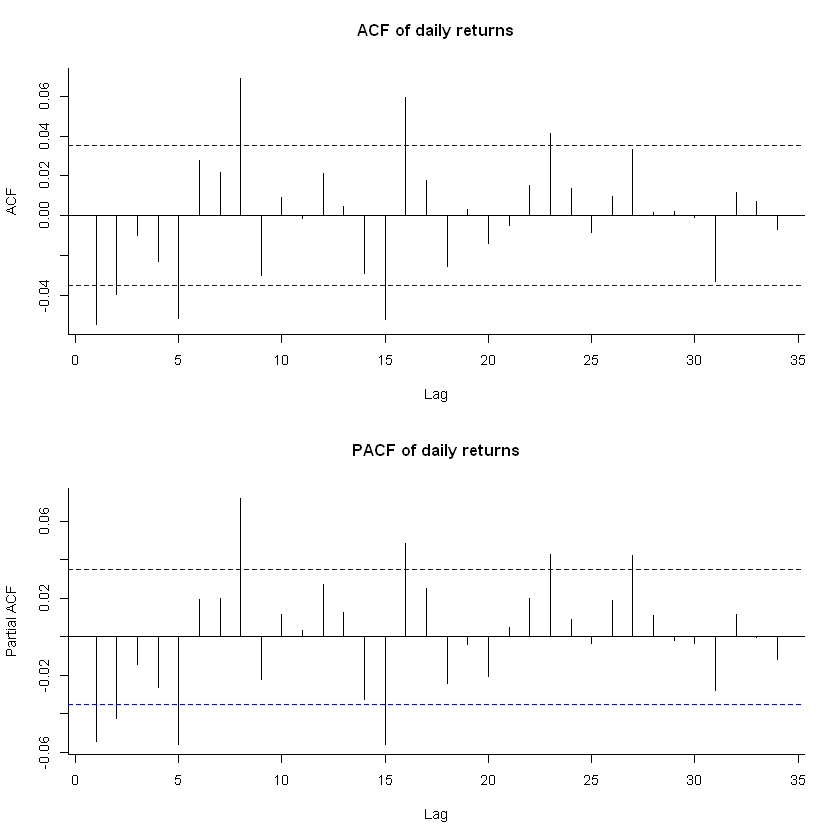

In [223]:
# Is there any autocorrelation within returns? #

#  First thing: check how ACF and PACF pltos look like #

require(forecast)
par(mfrow=c(2,1), cex=0.7, bty="l", lwd=1)
Acf(R, main="ACF of daily returns" )
Pacf(R, main="PACF of daily returns"  )



In [224]:
#Let's formalize it with some tests #

Box.test(R, lag = 20, type = c("Ljung-Box"))

#  Box- Ljung claims our data exhibits some serial correlation :( #


	Box-Ljung test

data:  R
X-squared = 73.18, df = 20, p-value = 5.465e-08


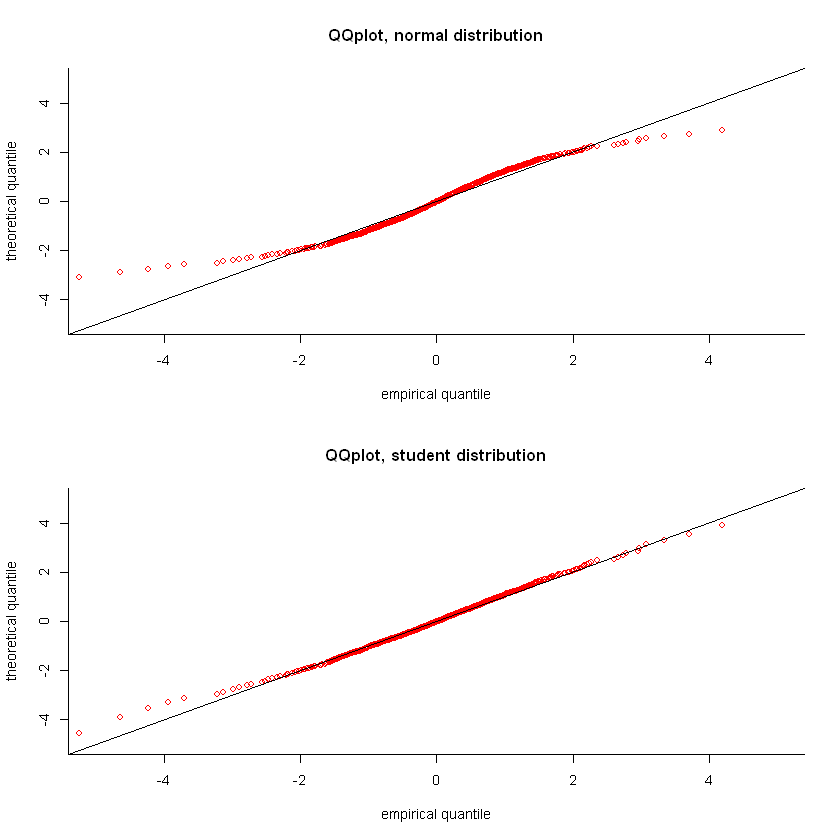

In [225]:
## We can see how QQ plots look like - using normal distribution as well as t-distribution ##


q            <- seq(0.001, 0.999, 0.001)

Qteo         <- qnorm(q)        # Normal distribution
Qteo1  <- qdist("std",p=q,shape=5) # SCALED t-distribution

Qemp         <- quantile(Rstar,q)         # our data

lim0    <- c(-5,5)                         
par(mfrow=c(2,1), cex = 0.7, bty="l")

plot(Qemp,Qteo, main="QQplot, normal distribution", col="red", xlim = lim0, ylim = lim0,
     xlab="empirical quantile", ylab="theoretical quantile") 
abline(a=0,b=1, lwd=1)

plot(Qemp,Qteo1, main="QQplot, student distribution", col="red", xlim = lim0, ylim = lim0,
     xlab="empirical quantile", ylab="theoretical quantile") 
abline(a=0,b=1, lwd=1)

#Important note#

## t-distribution fits our data clearly better ##

In [226]:
### So let's calculate Value at Risk of our portfolio applying different strategies ###


### 5 % Value at Risk -> Normal Distribution vs Student Distribution vs Historical simulation ###

# normal distribution 
p   <- 0.05      # tolerance level
m   <- mean(R) 
s   <- sd(R)
VaRnorm     <- qnorm(p)*s + m             
ESnorm      <- m - s*dnorm(qnorm(p))/p    
qf          <- function(x) qdist("norm", p=x)
ESnorm1     <- m + s*(1/p * integrate(qf, 0, p)$value) 

# t-distribution 
 v = 4 + 6/(kurtosis(R)-3)               # GMM estimate
# v <- fitdist("std", R)$pars["shape"]    # ML estimate
#v = 5

VaRt  <- m + s*qdist("std",shape=v,p=p)
qf    <- function(x) qdist("std", p=x, shape=v)
ESt   <- m + s*(1/p * integrate(qf, 0, p)$value) 

# Historical simulation
R0    <- sort(R)              
N0    <- floor(length(R0)*p)                            
VaRhs <- R0[N0]                      # compare to: quantile(R,p)
EShs  <- mean(R0[1:N0])        

tat <- as.data.frame(c(VaRnorm,VaRt,VaRhs,ESnorm,ESt,EShs))
rownames(tat) <- c("Value at Risk normal distribution","Value at Risk  t-distribution","Value at Risk  historical",
                   "Expected Shortfall normal distribution",
                   "Expected Shortfall t-distribution","Expected Shortfall historical") 

colnames(tat)="value"
kable(tat, digits=2)




### 5% Var is the biggest for normal distribution ###
### The biggest ES is for historical distribution ###



|                                       | value|
|:--------------------------------------|-----:|
|Value at Risk normal distribution      | -2.06|
|Value at Risk  t-distribution          | -1.95|
|Value at Risk  historical              | -1.89|
|Expected Shortfall normal distribution | -2.59|
|Expected Shortfall t-distribution      | -2.82|
|Expected Shortfall historical          | -2.93|

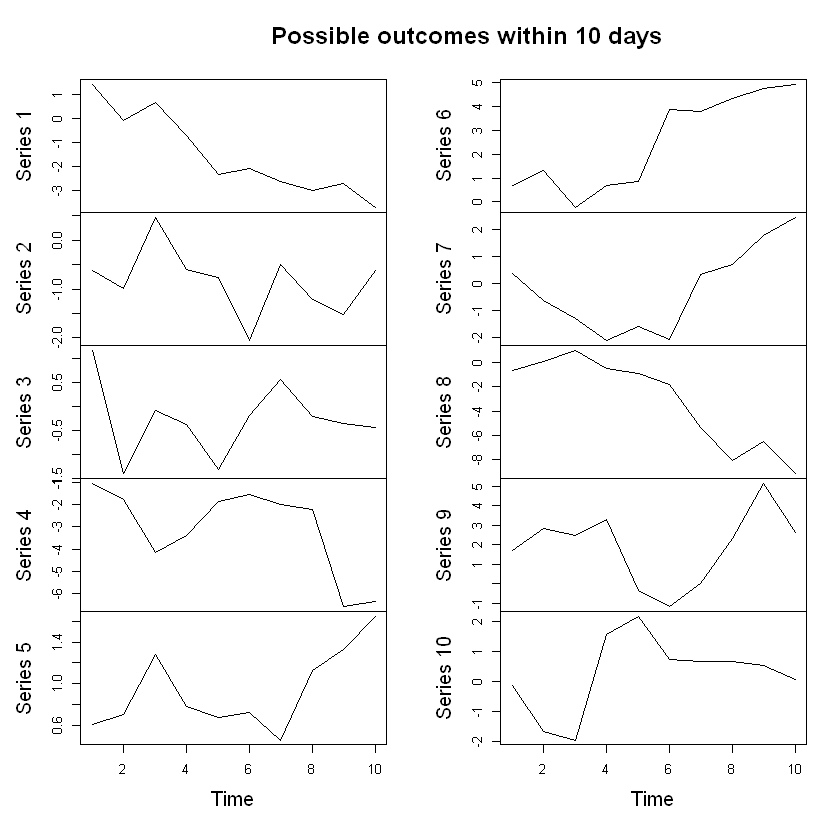

In [227]:
# 3b. VaR/ES for H-steap ahead horizon: 
# Normal, t-distribution, Historical Simulation
######################################################
### Now we can compute VaR and ES for 10 days ahead using 

H = 10 

## a) normal distribution: SQUARE ROOT OF TIME - ANALITICAL FORMULA ##

VaRHnorm <- sqrt(1:H)*qnorm(p)*s + (1:H)*m    
ESHnorm  <- (1:H)*m - sqrt(1:H)*s*dnorm(qnorm(p))/p    

## It's very convenient because we can use analitical formula - there is no need to use simulations ##


## b) t-distribution: Monte Carlo simulations ##

# We cannot derive it analitically so we have to apply MC to see how the distribution of cumulated returns may look like ##

Nsim    <- 10000
Rdraws  <- matrix(rdist(distribution="std", Nsim*H, mu = m, sigma = s, shape = v),H,Nsim) 
RdrawsC <- apply(Rdraws,2,cumsum)               # cumualted changes

VaRHt <- rep(NaN,H)
ESHt <- rep(NaN,H)
M0  <- floor(Nsim*p)     # observation for p-th quantile 

for(h in 1:H){
  temp   = sort(RdrawsC[h,])
  VaRHt[h] = temp[M0]
  ESHt[h]  = mean(temp[1:M0])
}


### Let's look at 10 possible paths ###

plot.ts(RdrawsC[,1:10], main = "Possible outcomes within 10 days")



In [228]:
## The same as above but in function form ##

RdrawsToVaRES <- function(RDraws,p){
  H    <- dim(Rdraws)[1]
  NSim <- dim(Rdraws)[2]
  RdrawsC <- apply(Rdraws,2,cumsum)               # cumualted changes
  VaR  <- ES <- rep(NaN,H)
  M0  <- floor(Nsim*p)     # observation for p-th quantile 
  for(h in 1:H){
    temp   = sort(RdrawsC[h,])
    VaR[h] = temp[M0]
    ES[h]  = mean(temp[1:M0])
  }
  return(list(VaR=VaR,ES=ES)) 
}


## c) Historical Simulation: Bootstrap ##

# We will use bootsrap to obtain a distribution of cumulated returns using historical data #

Rdraws  <- matrix(sample(R, Nsim*H, replace=TRUE),H,Nsim) 
temp   <- RdrawsToVaRES(RDraws,p)
VaRHhs <- temp$VaR
ESHhs  <- temp$ES

Ahead <- 1:10
beb <- cbind(Ahead,VaRHnorm,VaRHt,VaRHhs,ESHnorm, ESHt, ESHhs)

kable(beb,digit = 2)


## For 10 days ahead the biggest Var (5%) is obtained for t-distribution ###

## For 10 days ahead we have the biggest ES for historical simulation ###

## As we can see the value of Var increases rapidly from about -2 for H=1 to over 6 for H=10 ##



| Ahead| VaRHnorm| VaRHt| VaRHhs| ESHnorm|  ESHt| ESHhs|
|-----:|--------:|-----:|------:|-------:|-----:|-----:|
|     1|    -2.06| -1.94|  -1.83|   -2.59| -2.84| -2.77|
|     2|    -2.91| -2.83|  -2.65|   -3.65| -3.89| -3.90|
|     3|    -3.55| -3.41|  -3.28|   -4.46| -4.70| -4.64|
|     4|    -4.08| -3.95|  -3.78|   -5.14| -5.44| -5.40|
|     5|    -4.55| -4.44|  -4.38|   -5.74| -5.98| -6.06|
|     6|    -4.98| -4.93|  -4.81|   -6.27| -6.52| -6.55|
|     7|    -5.36| -5.33|  -5.22|   -6.77| -7.02| -7.10|
|     8|    -5.72| -5.65|  -5.53|   -7.22| -7.41| -7.44|
|     9|    -6.06| -5.92|  -5.92|   -7.65| -7.79| -7.93|
|    10|    -6.38| -6.25|  -6.27|   -8.05| -8.19| -8.29|

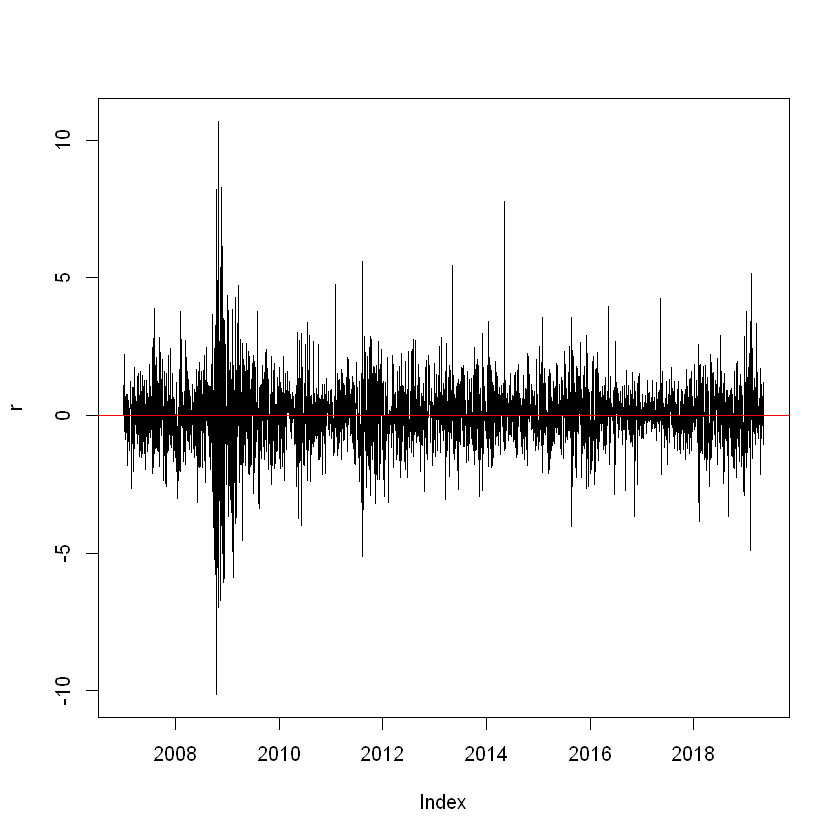

In [229]:
# Volatility clustering #
###########################################


# Let's take a look at the returns of our portfolio and find out whether our data exhibits volatility clustering #

plot(r); abline (h = 0 , col = "red")


# 2008 was very nervous - that's for sure #
# Then we can observe some periods of higer volatility in the next few years #
# It may mean conditional heteroscedasticity is present within returns #


	Box-Ljung test

data:  R^2
X-squared = 3747.1, df = 20, p-value < 2.2e-16


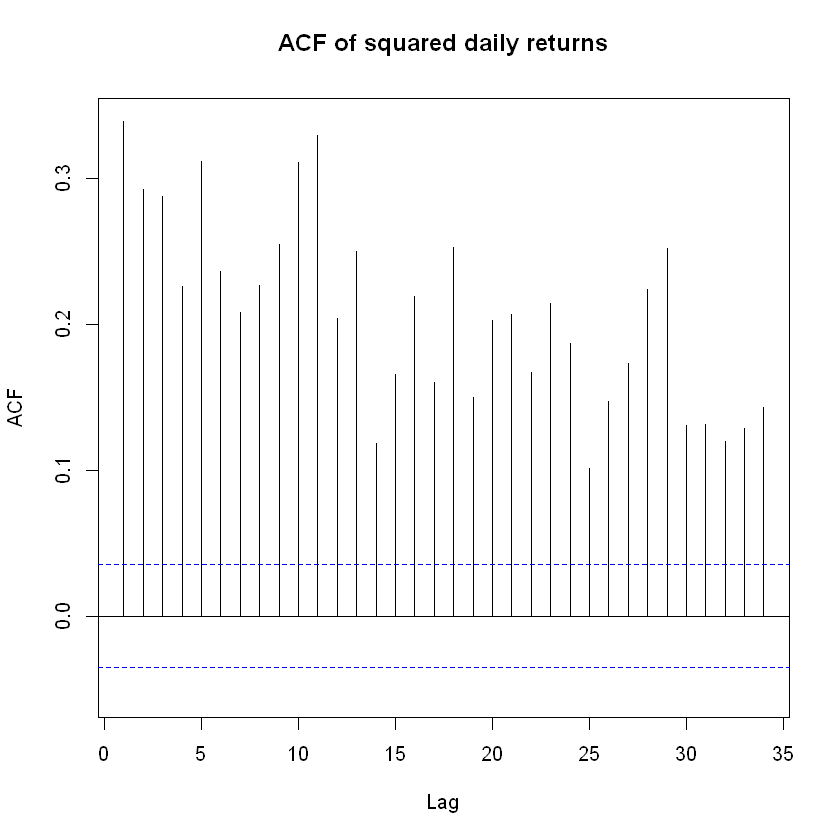

In [230]:
Acf(R^2, main="ACF of squared daily returns" )
Box.test(R^2, lag = 20, type = c("Ljung-Box"))

### Box-Ljung suggest the ARCH effect is present ###

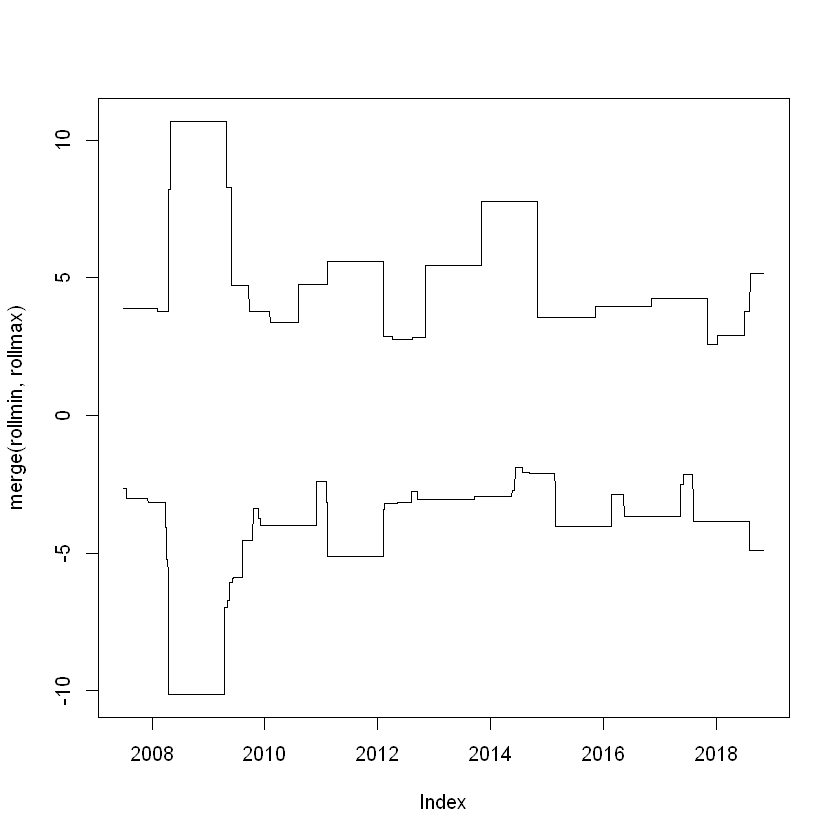

In [231]:
# Let's detect the periods of increased volatility #


# min-max spread
rollmin <- rollapply(r, width=Nyear, min, by=1)
rollmax <- rollapply(r, width=Nyear, max, by=1)
plot(merge(rollmin,rollmax),screens=c(1,1))

#2008 obviously
# about 2011
# maybe 2014 ?

#### Is 2019 going to be nervous? ####

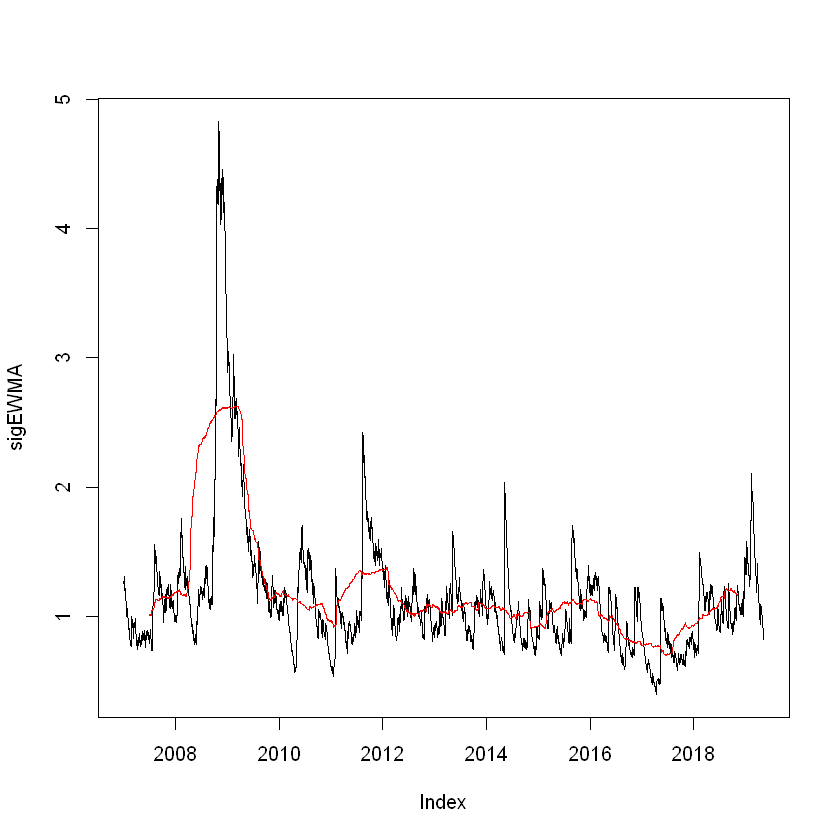

In [232]:
# We can try to model the volatility #


# Firstly let's have a look at 2 basic strategies #



### Rolling Standard Deviation (1 year window) ###


sigROLL <- rollapply(r, width=Nyear, sd, by=1)

# The problem with rolling SD is the fact once the calculation period (f.e. 1 year) is over and some observations are not loger included
# the curve may suddenly drop - is it reasonable?




#### Exponentially Weighted Moving Average EWMA / riskMetrics (developed by JP Morgan) ####


# We can try to adress that problem using EWMA -
# observation have influence all the time but with smaller and smaller weight #



lambda      <- 0.94                         

 # smoothing parameter was initially calibrated by JP Morgan's economists
 # See RiskMetrics 1994


temp        <- rep(0,length(R))
temp[1]     <- var(R)                        # starting point -> sample average
for (t in 2:length(R)){             
  temp[t] = lambda * temp[t-1]  + (1-lambda) * R[t-1]^2
}
sigEWMA      <- zoo(temp^0.5,order.by=index(r))

plot(sigEWMA)
lines(sigROLL,col='red')

In [233]:
### OK, let's move to my favourite part - GARCH model ###



## 1) Specification -> (1,1) so the most common one

spec0 = ugarchspec(variance.model=list(model="sGARCH", garchOrder=c(1,1)), 
                   mean.model=list(armaOrder=c(0,0), include.mean=TRUE),  
                   distribution.model="std")


## 2) Fitting the data

fit0 = ugarchfit(data=r, spec=spec0) # solver="nlminb"

fit0
sigGARCH <- as.zoo(sigma(fit0))


# We can also compute the equilibrium level ! #

sig2eq = fit0@fit$coef["omega"]/(1-fit0@fit$coef["alpha1"]-fit0@fit$coef["beta1"])

(sqrt(sig2eq))

# It's about 1.22 #


*---------------------------------*
*          GARCH Model Fit        *
*---------------------------------*

Conditional Variance Dynamics 	
-----------------------------------
GARCH Model	: sGARCH(1,1)
Mean Model	: ARFIMA(0,0,0)
Distribution	: std 

Optimal Parameters
------------------------------------
        Estimate  Std. Error  t value Pr(>|t|)
mu      0.053595    0.017254   3.1063 0.001895
omega   0.030667    0.010679   2.8717 0.004082
alpha1  0.078882    0.015130   5.2137 0.000000
beta1   0.900613    0.020021  44.9840 0.000000
shape   7.099210    0.836335   8.4885 0.000000

Robust Standard Errors:
        Estimate  Std. Error  t value Pr(>|t|)
mu      0.053595    0.015737   3.4056 0.000660
omega   0.030667    0.015779   1.9436 0.051949
alpha1  0.078882    0.025248   3.1243 0.001782
beta1   0.900613    0.032740  27.5079 0.000000
shape   7.099210    0.993048   7.1489 0.000000

LogLikelihood : -4672.428 

Information Criteria
------------------------------------
                

omega 
1.222963

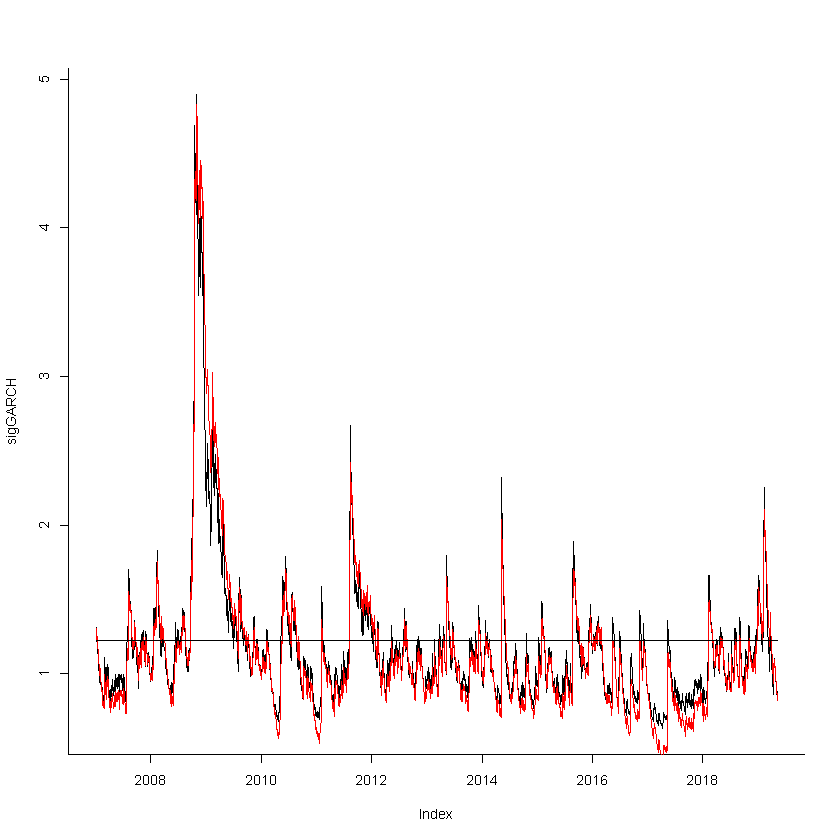

In [234]:
# Red line presents volatility modeled by EWMA, the black one accounts for GARCH(1,1) model

# Horizontal line is set at equilibrium level computed from GARCH model #

par(mfrow=c(1,1), cex = 0.7, bty="l")
plot(sigGARCH)
lines(sigEWMA,col='red')
lines(zoo(sqrt(sig2eq),index(sigGARCH)))


	Box-Ljung test

data:  u^2
X-squared = 8.8721, df = 12, p-value = 0.7138


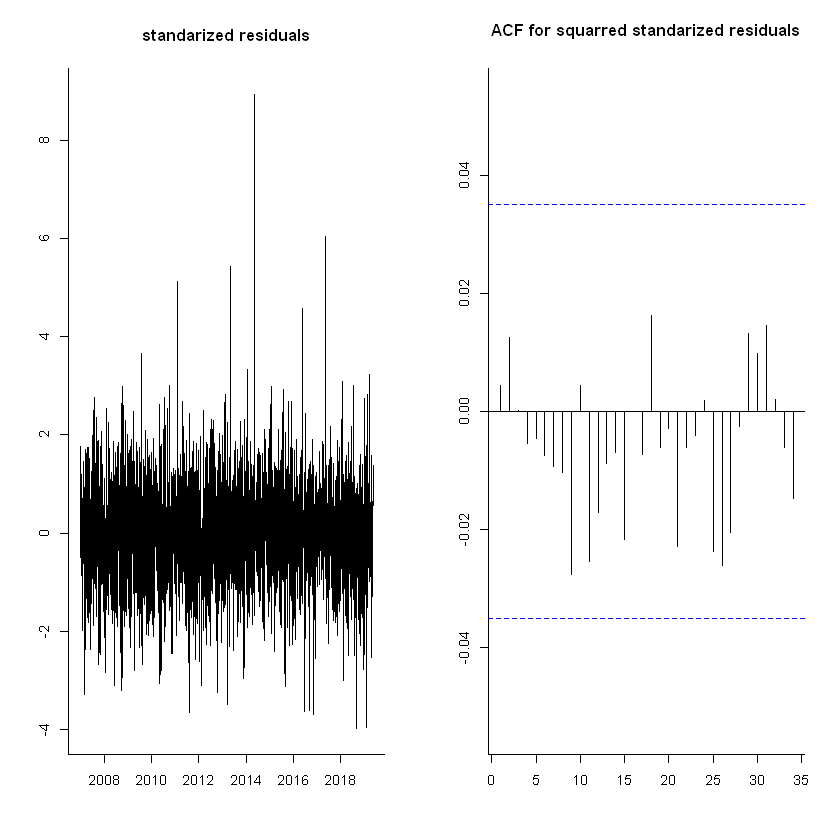

In [235]:
# Now we can standarize the residuals from GARCH(1,1) model


u   <- as.zoo(residuals(fit0)/sigma(fit0))

par(mfrow=c(1,2), cex=0.7, bty="l", lwd=1)
plot(u, main="standarized residuals", xlab="", ylab="")
Acf(coredata(u)^2, main="ACF for squarred standarized residuals", xlab="", ylab="")

Box.test(u^2, lag=12, type='Ljung')


#That looks awesome I guess #
# Note: There is no serial correlation in standarized residuals #

# Our good friends Box and Ljungs confirmed that fact #
# Thanks guys! #


please wait...calculating quantiles...


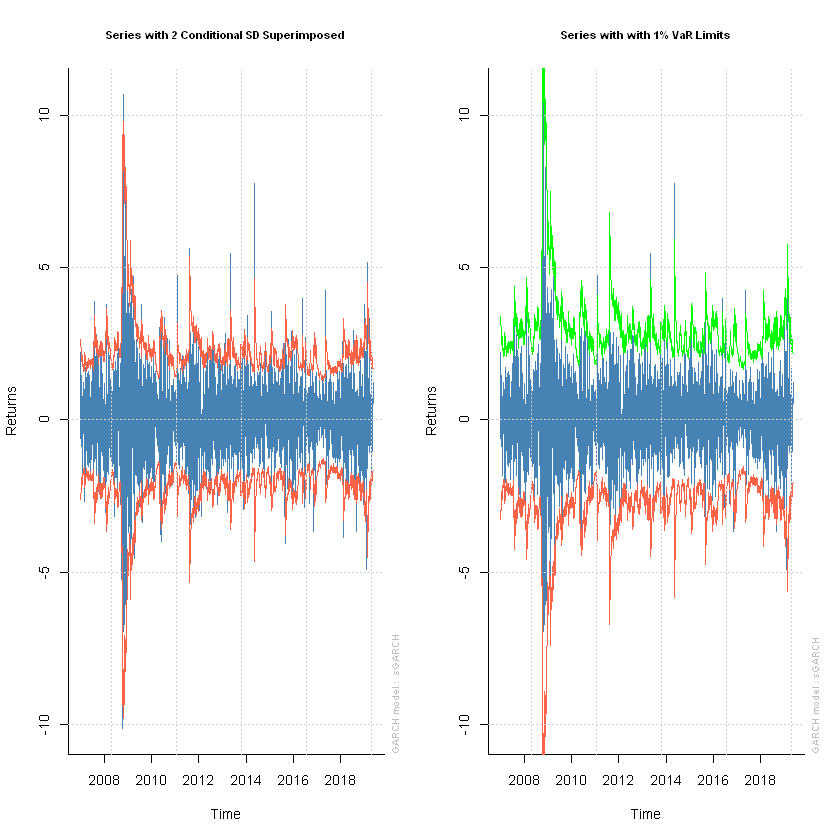

In [236]:
par(mfrow=c(1,2), cex=0.7, bty="l", lwd=1)
plot(fit0, which=1)
plot(fit0, which=2)


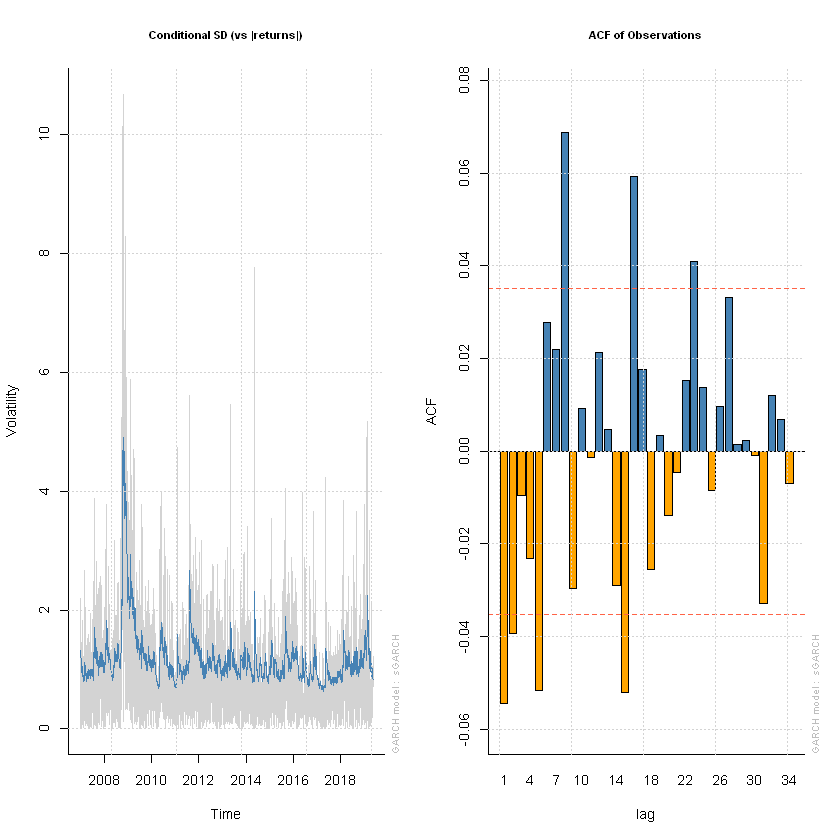

In [237]:
par(mfrow=c(1,2), cex=0.7, bty="l", lwd=1)
plot(fit0, which=3)
plot(fit0, which=4)

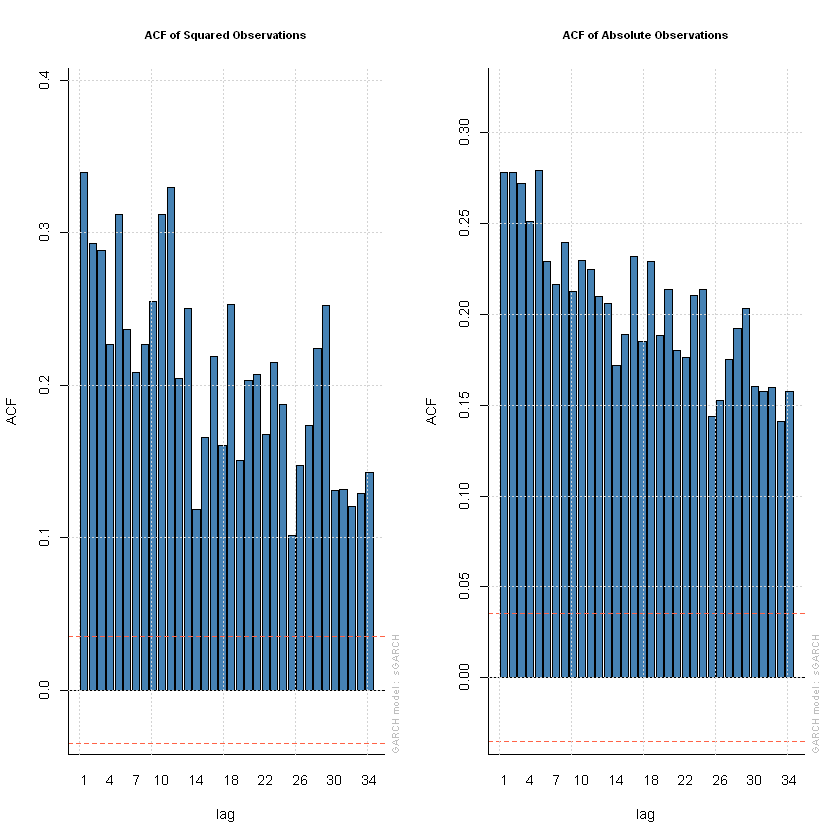

In [238]:
par(mfrow=c(1,2), cex=0.7, bty="l", lwd=1)
plot(fit0, which=5)
plot(fit0, which=6)

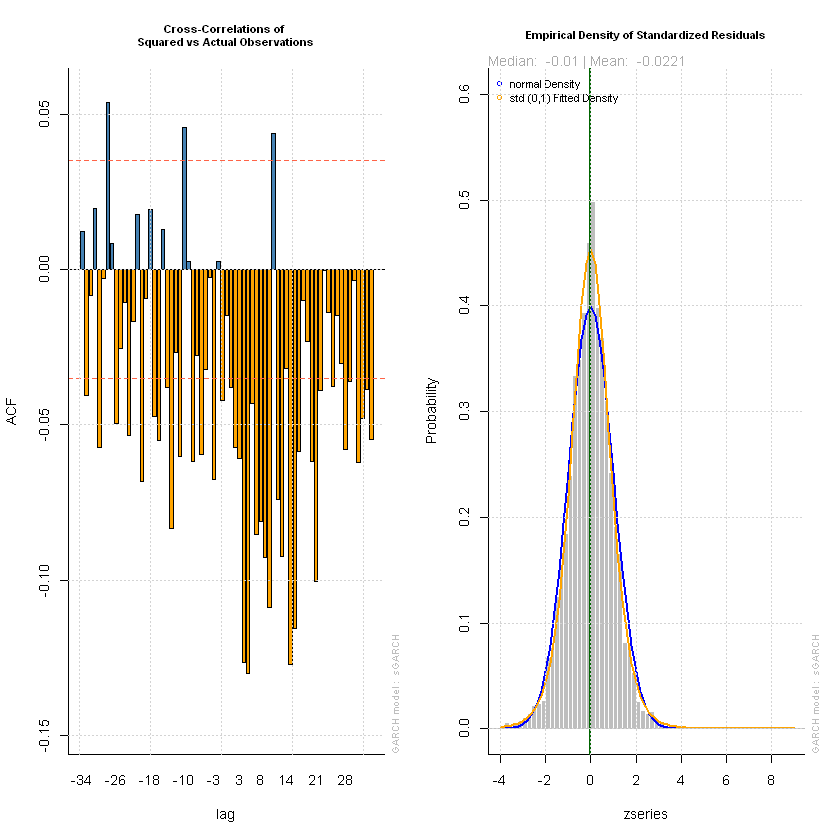

In [239]:
par(mfrow=c(1,2), cex=0.7, bty="l", lwd=1)
plot(fit0, which=7)
plot(fit0, which=8)

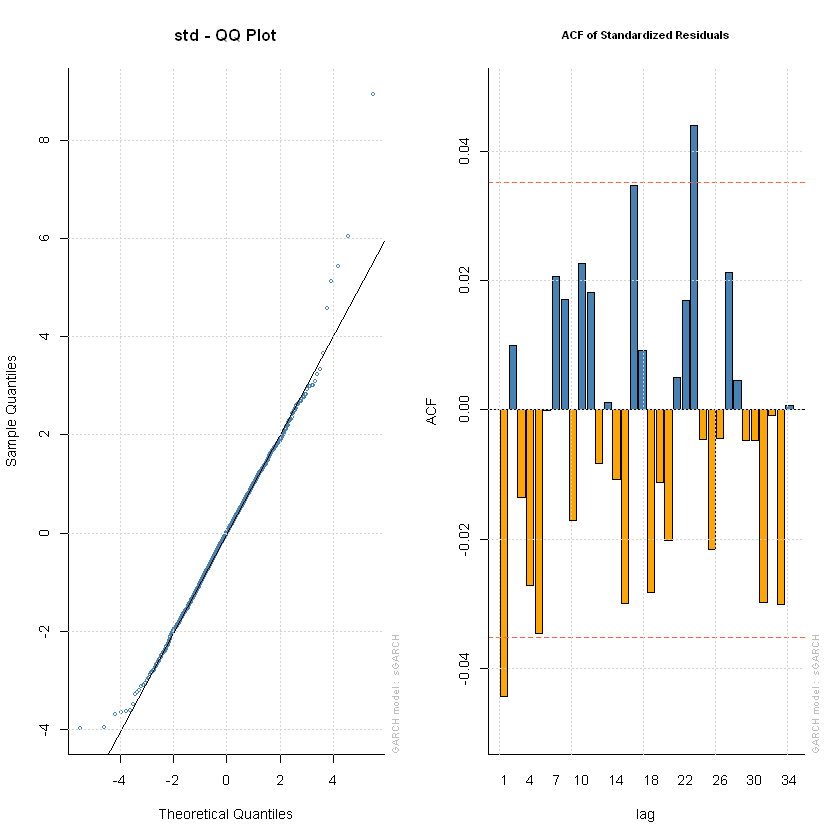

In [240]:
par(mfrow=c(1,2), cex=0.7, bty="l", lwd=1)
plot(fit0, which=9)
plot(fit0, which=10)

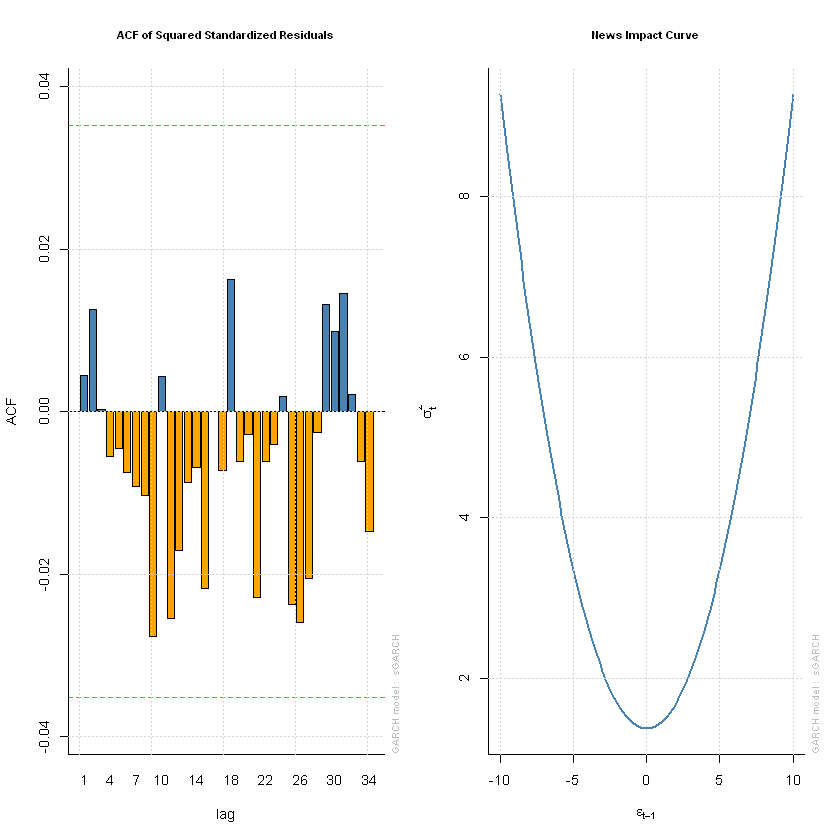

In [241]:
par(mfrow=c(1,2), cex=0.7, bty="l", lwd=1)
plot(fit0, which=11)
plot(fit0, which=12)

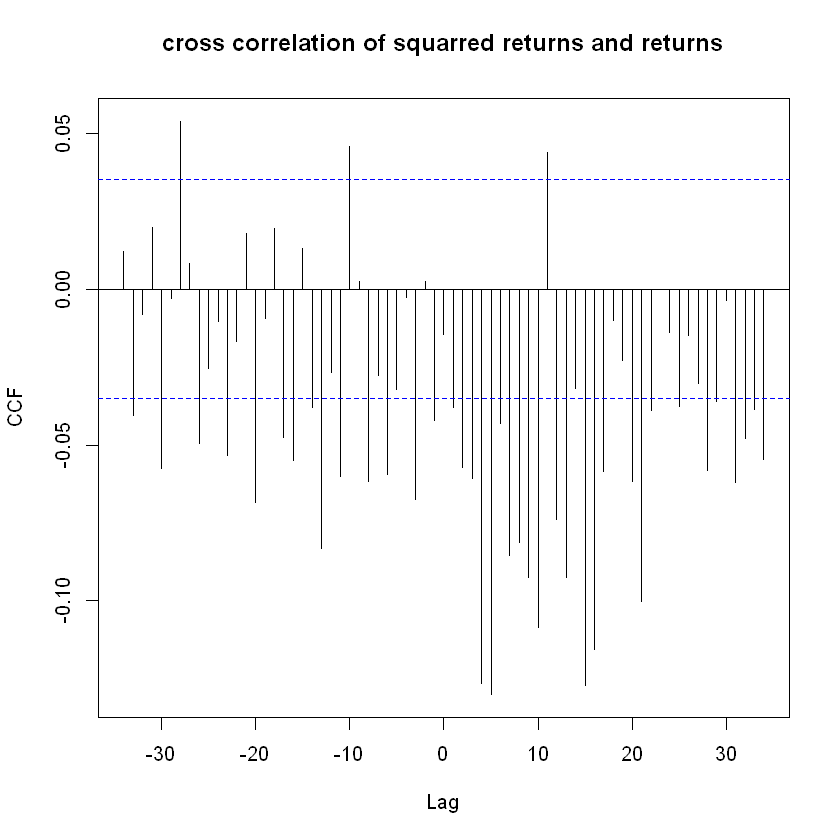

In [242]:
# Leverage effect - Black 1976

# Volatility tends to increase more as a result of drop in price rather than as a result of increase in price #

Ccf(R^2,R, type="correlation", main="cross correlation of squarred returns and returns")


In [243]:
### LAG SELECTION - IT MAY TAKE 1 or 2 MIN ###

# We can choose p and q, based on information criteria #


LagSel <- function(x, Pmax=4, Qmax=4, crit="SIC", dist="std"){
  IC <- matrix(NA, Pmax, Qmax+1)
  for(p in 1:Pmax){
    for(q in 0:Qmax){
      
      spec = ugarchspec(variance.model=list(model="sGARCH", garchOrder=c(p,q)), 
                        mean.model=list(armaOrder=c(0,0), include.mean=TRUE),  
                        distribution.model=dist)
      fit  = ugarchfit(data=x, spec=spec, solver.control = list(tol = 1e-12)) # Outcome does't converge so we have to specify solver control
      if(crit == "AIC"){IC[p,q+1] <- infocriteria(fit)[1] }
      if(crit == "SIC"){IC[p,q+1] <- infocriteria(fit)[2] }
      if(crit == "HQ"){	IC[p,q+1] <- infocriteria(fit)[4] }
    }
  }
  rownames(IC) <- paste('p=',1:Pmax, sep="")
  colnames(IC) <- paste('q=',0:Qmax, sep="")
  return(IC)
}

LagSel(r,4,4,crit="SIC", dist="std")
LagSel(r,4,4,crit="SIC", dist="norm")

,q=0,q=1,q=2,q=3,q=4
p=1,3.094427,3.017707,3.020306,3.022292,3.024630
p=2,3.071324,3.020360,3.022891,3.024660,3.026939
p=3,3.054532,3.022703,3.025235,3.027246,3.029525
p=4,3.048563,3.025387,3.027919,3.029792,3.032111


,q=0,q=1,q=2,q=3,q=4
p=1,3.183124,3.063393,3.065828,3.067613,3.069808
p=2,5.799061,3.066036,3.068414,3.070175,3.072305
p=3,3.105398,3.068359,3.070736,3.072761,3.074891
p=4,3.096805,3.071062,3.073440,3.075406,3.077477


In [244]:
# The "best" model is GARCH (1,1) as presented above #

pq   = c(1,1)
PQ   = c(0,0)
dist = "std"


# Assymetric models #

#Let's go with exponential GARCH#
# In this way we let the volatility react assymetrically to the bad and good news #

spec.e   = ugarchspec(variance.model=list(model="eGARCH", garchOrder=pq), 
                      mean.model=list(armaOrder=PQ, include.mean=TRUE),  
                      distribution.model=dist)

# Alternatively we can use gjr-GARCH, Glosten, Jagannathana i Runkle (1993) 

spec.gjr = ugarchspec(variance.model=list(model="gjrGARCH", garchOrder=pq), 
                      mean.model=list(armaOrder=PQ, include.mean=TRUE),  
                      distribution.model=dist)

fit.e   = ugarchfit(data=r, spec=spec.e)    # solver="nlminb"
fit.gjr = ugarchfit(data=r, spec=spec.gjr)

# GARCH-in-Mean (GARCH-M) #
# In this model we assume the returns may be influenced by the volatility #
# Market demands higer volatilty to be bounded with higer bonus #
# So the higher conditional volatility should be related to higer returns #

mod = "gjrGARCH"
spec.m = ugarchspec(variance.model=list(model=mod, garchOrder=pq), 
                    mean.model=list(armaOrder=PQ, include.mean=TRUE, archm = TRUE), distribution.model=dist)
fit.m  = ugarchfit(data=r, spec=spec.m)

IC <- cbind(infocriteria(fit0), infocriteria(fit.e), infocriteria(fit.gjr), infocriteria(fit.m))
colnames(IC) <- c("GARCH", "eGARCH", "gjrGARCH","GARCH-in-mean")
IC


,GARCH,eGARCH,gjrGARCH,GARCH-in-mean
Akaike,3.007992,2.989593,2.991956,2.992426
Bayes,3.017707,3.001250,3.003614,3.006026
Shibata,3.007987,2.989585,2.991949,2.992416
Hannan-Quinn,3.011480,2.993778,2.996142,2.997309


In [245]:
# All of the information criteria indicate eGARCH #

spec2 = ugarchspec(variance.model=list(model="eGARCH", garchOrder=pq), 
                   mean.model=list(armaOrder=PQ, include.mean=TRUE), distribution.model=dist)


fit2  = ugarchfit(data=r, spec=spec2)


# 8. Analitical VaR/ES for h=1 from the best GARCH model
########################################################

p <- 0.05                        # tolerance level
v <- fit2@fit$coef["shape"]      # shape of t-distribution

# help(ugarchforecast)
fct2 <- ugarchforecast(fit2,data=r, n.ahead = 1)
sig <- sigma(fct2)
mu  <- fitted(fct2)

qf   <- function(x) qdist("std", p=x, shape=v)
#qf   <- function(x) qdist("norm", p=x)
(VaRgarch <- mu + sig*qdist("std", p, shape=v))
(ESgarch  <- mu + sig*(1/p * integrate(qf, 0, p)$value)  )

# As for 5th of May 2019 #

# 5% VaR of our portfolio for one day ahead was about 1.44 #
# Expected Shortfall is calculated to be about 1.97 #

,2019-05-10
T+1,-1.387954


,2019-05-10
T+1,-1.9037


In [250]:
library(FinTS)

res_garch_roll <- ugarchroll(spec0, r, n.start = 120, refit.every = 1,
                             refit.window = "moving", solver = "hybrid", 
                             calculate.VaR = TRUE, VaR.alpha = 0.05, 
                             keep.coef = TRUE, solver.control = list(tol = 1e-7, delta = 1e-9),
                             fit.control = list(scale = 1))

report(res_garch_roll, VaR.alpha = 0.05)

# The results of Kupiec and Christoffersend differ #
# But the p-value of Kupiec test is almost 0.05 so we assume our model performs just fine#

Warning message:
"package 'FinTS' was built under R version 3.5.3"
Attaching package: 'FinTS'

The following object is masked from 'package:forecast':

    Acf



VaR Backtest Report
Model:				sGARCH-std
Backtest Length:	2990
Data:				

alpha:				5%
Expected Exceed:	149.5
Actual VaR Exceed:	174
Actual %:			5.8%

Unconditional Coverage (Kupiec)
Null-Hypothesis:	Correct Exceedances
LR.uc Statistic:	4.024
LR.uc Critical:		3.841
LR.uc p-value:		0.045
Reject Null:		YES

Conditional Coverage (Christoffersen)
Null-Hypothesis:	Correct Exceedances and
					Independence of Failures
LR.cc Statistic:	4.874
LR.cc Critical:		5.991
LR.cc p-value:		0.087
Reject Null:		NO


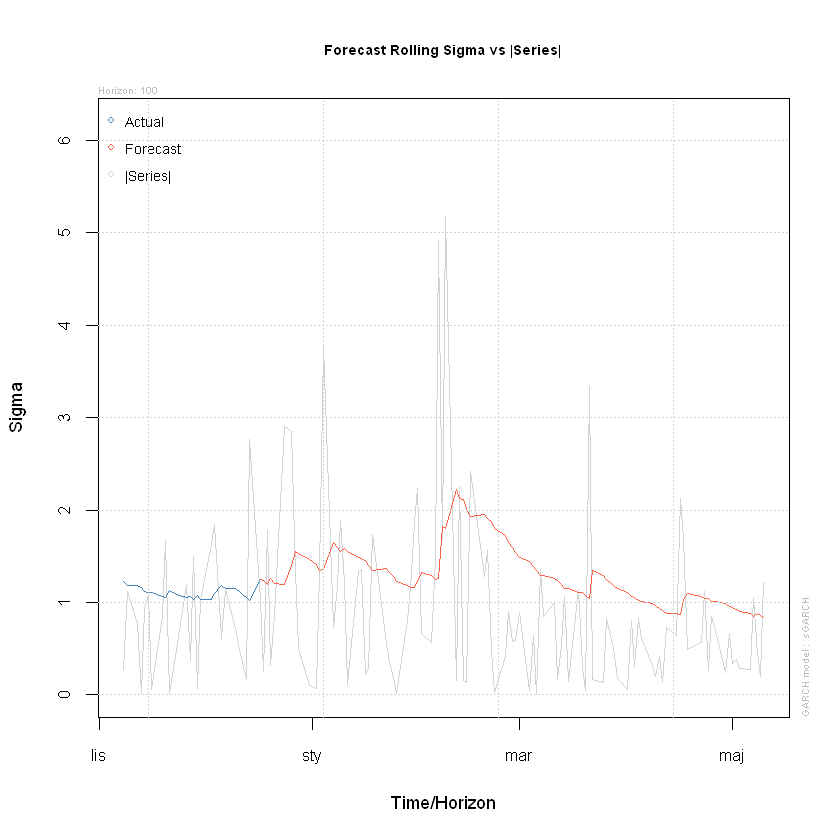

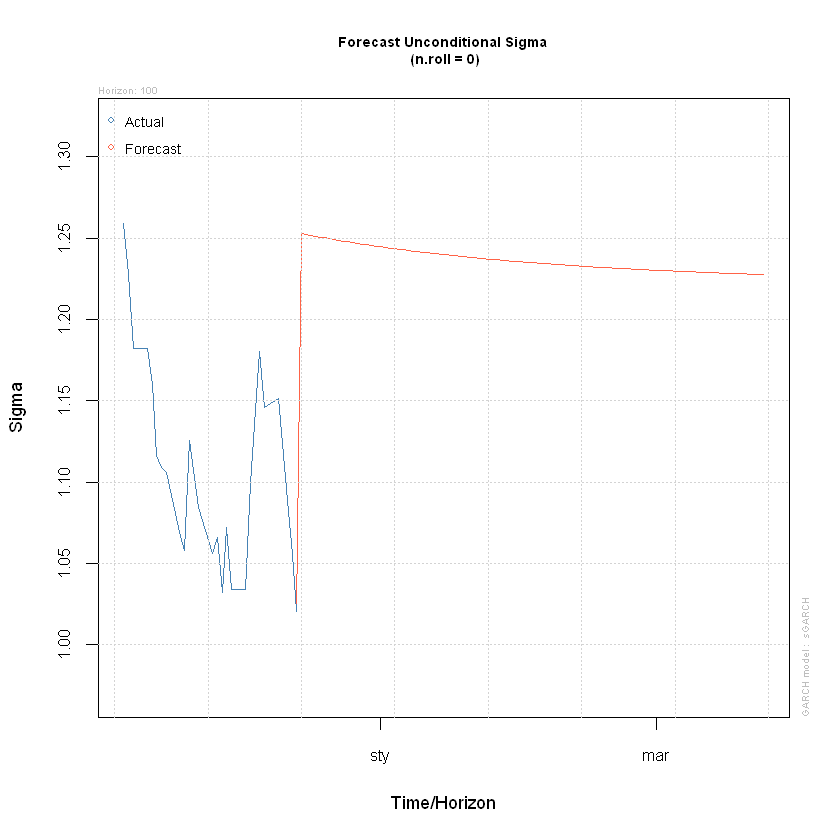

In [248]:
## Some basic forecasting ##

fit = ugarchfit(data = r, spec = spec0, out.sample = 100)
forc1 = ugarchforecast(fit, n.ahead=100, n.roll = 100)

plot(forc1, which = 4)
plot(forc1, which = 3)

In [249]:
# It turns out our model performs fine and can be used for modeling and predicting purposes #